In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [13]:
file = pd.read_csv("data/Focus.csv", skiprows=1, 
                    usecols=['EEG.Cz', 'EEG.Fz', 'EEG.Fp1', 'EEG.F7',
                            'EEG.F3', 'EEG.FC1', 'EEG.C3', 'EEG.FC5',
                            'EEG.FT9', 'EEG.T7', 'EEG.CP5', 'EEG.CP1',
                            'EEG.P3', 'EEG.P7', 'EEG.PO9', 'EEG.O1',
                            'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.PO10',
                            'EEG.P8', 'EEG.P4', 'EEG.CP2', 'EEG.CP6',
                            'EEG.T8', 'EEG.FT10', 'EEG.FC6', 'EEG.C4',
                            'EEG.FC2', 'EEG.F4', 'EEG.F8', 'EEG.Fp2'])
df = pd.DataFrame(file)

In [14]:
def get_mean_electrode(slice, electrode):
    value = 0
    for i in range(slice.shape[0]):
        value += slice[i][electrode]
    return value / slice.shape[0]
        

In [15]:
def rescale_dataset(dataset, scale):
    scaled_set = torch.zeros([(int)(dataset.shape[0] / scale), dataset.shape[1]])
    for i in range(scaled_set.shape[0]):
        slice_of_ten = dataset[(i * scale):(i * scale + scale)]
        for j in range(scaled_set.shape[1]):
            scaled_set[i][j] = get_mean_electrode(slice_of_ten, j)
    return scaled_set

In [16]:
vanilla_data = df.to_numpy()
normalized_data = (vanilla_data - np.min(vanilla_data)) / (np.max(vanilla_data) - np.min(vanilla_data))
standardized_data = normalized_data - normalized_data.mean()
large_data = torch.Tensor(standardized_data)

train_set = rescale_dataset(large_data, 10)

In [17]:
def get_mean_values(dataset):
    mean_values = [0] * dataset.shape[0]
    for i in range(dataset.shape[0]):
        mean_values[i] = dataset[i].mean()
    return mean_values

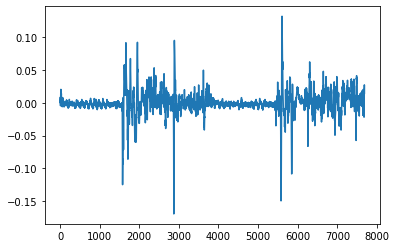

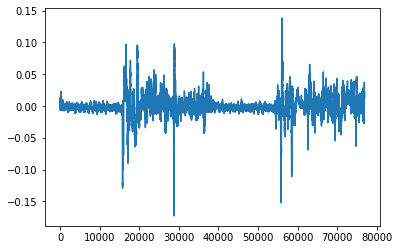

In [18]:
plt.plot(get_mean_values(train_set))
plt.show()
plt.plot(get_mean_values(large_data))
plt.show()

In [19]:
def labelize_set(train_set):
    result = list()
    for index, element in enumerate(train_set):
        if (index < 1500 or (index > 3900 and index < 5400)):
            result.append((element, 0))
        else:
            result.append((element, 1))
    return result
    
labelled_set = labelize_set(train_set)
focusedCount = 0
for signals, labels in labelled_set:
    if (labels == 0):
        focusedCount+=1
focusedCount / train_set.shape[0] * 100

39.01899557637263

In [20]:
random.shuffle(labelled_set)
train_size = (int)(len(labelled_set) * 0.8)
test_size = len(labelled_set) - train_size
train_set = labelled_set[0:train_size]
test_set = labelled_set[train_size:train_size+test_size]

In [21]:
import time
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Convolution layer
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.max_pool = nn.MaxPool1d(2)
        # --------------------------------

        self.dropout = nn.Dropout(0.25)

        # Fully connected layer
        self.linear1 = nn.Linear(16 * 5, 120)
        self.linear2 = nn.Linear(120, 2)
        # --------------------------------

    def forward(self, x):
        x = x.view(64, 1, 32)
        # Convolution layer
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # -----------------------

        x = self.dropout(x)

        # Flatten filters
        x = x.view(-1, 16 * 5)

        # Fully connected layer
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        # -------------------------
        return x

In [23]:
network = NeuralNetwork()

LEARNING_RATE = 0.05
EPOCH = 100
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
# # Load a loss calculator and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE, momentum=0.9)

iteration = 0
start_time = time.time()

train_accuracies = np.zeros(EPOCH)
test_accuracies = np.zeros(EPOCH)

for iteration in range(EPOCH):
    average_loss = 0.0

    print("――――――――――――――――――――――――――――――――――――――――――――――――――")

    # Training
    total = 0
    success = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        try:
            output = network.forward(inputs)
        except:
            continue
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        average_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        success += (predicted == labels.data).sum()
    train_accuracies[iteration] = 100.0 * success / total
    print(train_accuracies[iteration])
    # -------------------------------------------------------------------

    # Testing
    total = 0
    success = 0
    for inputs, labels in tqdm(test_loader):
        try:
            output = network.forward(inputs)
        except:
            continue
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        success += (predicted == labels.data).sum()
    test_accuracies[iteration] = 100.0 * success / total
    # -------------------------------------------------------------------

    print(u"Epoch {}, average loss {}, train accuracy {}, test accuracy {}".format(
        iteration,
        average_loss / len(train_loader),
        train_accuracies[iteration],
        test_accuracies[iteration]
    ))

――――――――――――――――――――――――――――――――――――――――――――――――――
61.10026168823242


100%|██████████| 25/25 [00:00<00:00, 1279.17it/s]


Epoch 0, average loss 0.6623662212460312, train accuracy 61.10026168823242, test accuracy 59.11458206176758
――――――――――――――――――――――――――――――――――――――――――――――――――
61.474609375


100%|██████████| 25/25 [00:00<00:00, 1456.62it/s]


Epoch 1, average loss 0.66002897687794, train accuracy 61.474609375, test accuracy 59.11458206176758
――――――――――――――――――――――――――――――――――――――――――――――――――
61.45833206176758


100%|██████████| 25/25 [00:00<00:00, 1473.86it/s]


Epoch 2, average loss 0.6587168678794939, train accuracy 61.45833206176758, test accuracy 59.04948043823242
――――――――――――――――――――――――――――――――――――――――――――――――――
61.44205856323242


100%|██████████| 25/25 [00:00<00:00, 1382.47it/s]


Epoch 3, average loss 0.6552306794628655, train accuracy 61.44205856323242, test accuracy 59.11458206176758
――――――――――――――――――――――――――――――――――――――――――――――――――
61.45833206176758


100%|██████████| 25/25 [00:00<00:00, 1368.92it/s]

Epoch 4, average loss 0.6375385848517271, train accuracy 61.45833206176758, test accuracy 59.11458206176758
――――――――――――――――――――――――――――――――――――――――――――――――――


66.17838287353516


100%|██████████| 25/25 [00:00<00:00, 1265.66it/s]

Epoch 5, average loss 0.5509506488583752, train accuracy 66.17838287353516, test accuracy 80.078125
――――――――――――――――――――――――――――――――――――――――――――――――――


77.21353912353516


100%|██████████| 25/25 [00:00<00:00, 1404.62it/s]

Epoch 6, average loss 0.4552043396787545, train accuracy 77.21353912353516, test accuracy 67.578125
――――――――――――――――――――――――――――――――――――――――――――――――――


82.89388275146484


100%|██████████| 25/25 [00:00<00:00, 1426.81it/s]

Epoch 7, average loss 0.4073130970763177, train accuracy 82.89388275146484, test accuracy 63.73698043823242
――――――――――――――――――――――――――――――――――――――――――――――――――


86.60482025146484


100%|██████████| 25/25 [00:00<00:00, 1451.30it/s]

Epoch 8, average loss 0.3797669509022506, train accuracy 86.60482025146484, test accuracy 87.109375
――――――――――――――――――――――――――――――――――――――――――――――――――


88.28125


100%|██████████| 25/25 [00:00<00:00, 1456.52it/s]

Epoch 9, average loss 0.3694831913279504, train accuracy 88.28125, test accuracy 93.359375
――――――――――――――――――――――――――――――――――――――――――――――――――


89.66471099853516


100%|██████████| 25/25 [00:00<00:00, 1217.94it/s]

Epoch 10, average loss 0.36251554307863887, train accuracy 89.66471099853516, test accuracy 89.77864837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


91.37369537353516


100%|██████████| 25/25 [00:00<00:00, 1466.93it/s]

Epoch 11, average loss 0.3466715625266439, train accuracy 91.37369537353516, test accuracy 92.578125
――――――――――――――――――――――――――――――――――――――――――――――――――


93.19661712646484


100%|██████████| 25/25 [00:00<00:00, 1428.97it/s]

Epoch 12, average loss 0.336978129351262, train accuracy 93.19661712646484, test accuracy 95.5078125
――――――――――――――――――――――――――――――――――――――――――――――――――


93.48958587646484


100%|██████████| 25/25 [00:00<00:00, 1449.91it/s]

Epoch 13, average loss 0.3314739533306397, train accuracy 93.48958587646484, test accuracy 95.05208587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


92.3828125


100%|██████████| 25/25 [00:00<00:00, 1487.30it/s]

Epoch 14, average loss 0.33564329055166736, train accuracy 92.3828125, test accuracy 93.61978912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


93.37564849853516


100%|██████████| 25/25 [00:00<00:00, 665.10it/s]

Epoch 15, average loss 0.3271067014981791, train accuracy 93.37564849853516, test accuracy 94.79166412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


93.27799224853516


100%|██████████| 25/25 [00:00<00:00, 1160.33it/s]

Epoch 16, average loss 0.32943602274988115, train accuracy 93.27799224853516, test accuracy 91.92708587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


93.66861724853516


100%|██████████| 25/25 [00:00<00:00, 1310.03it/s]

Epoch 17, average loss 0.32806244769047216, train accuracy 93.66861724853516, test accuracy 94.85677337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


94.12435150146484


100%|██████████| 25/25 [00:00<00:00, 413.77it/s]

Epoch 18, average loss 0.3193599103959565, train accuracy 94.12435150146484, test accuracy 95.05208587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


94.07552337646484


100%|██████████| 25/25 [00:00<00:00, 761.31it/s]

Epoch 19, average loss 0.3200998780960889, train accuracy 94.07552337646484, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――


94.27083587646484


100%|██████████| 25/25 [00:00<00:00, 1301.22it/s]

Epoch 20, average loss 0.3192126253216537, train accuracy 94.27083587646484, test accuracy 95.05208587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


93.75


100%|██████████| 25/25 [00:00<00:00, 1348.98it/s]

Epoch 21, average loss 0.3226389606896135, train accuracy 93.75, test accuracy 96.22396087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


94.62890625


100%|██████████| 25/25 [00:00<00:00, 1376.10it/s]

Epoch 22, average loss 0.3152933357302676, train accuracy 94.62890625, test accuracy 95.37760162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


94.04296875


100%|██████████| 25/25 [00:00<00:00, 1184.87it/s]

Epoch 23, average loss 0.3191926230474846, train accuracy 94.04296875, test accuracy 94.921875
――――――――――――――――――――――――――――――――――――――――――――――――――


95.27994537353516


100%|██████████| 25/25 [00:00<00:00, 1391.70it/s]

Epoch 24, average loss 0.3105649885135828, train accuracy 95.27994537353516, test accuracy 95.57291412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.18228912353516


100%|██████████| 25/25 [00:00<00:00, 1346.97it/s]

Epoch 25, average loss 0.3125862299474244, train accuracy 95.18228912353516, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.05208587646484


100%|██████████| 25/25 [00:00<00:00, 1402.61it/s]

Epoch 26, average loss 0.30819297174817506, train accuracy 95.05208587646484, test accuracy 94.53125
――――――――――――――――――――――――――――――――――――――――――――――――――


95.13346099853516


100%|██████████| 25/25 [00:00<00:00, 1207.47it/s]

Epoch 27, average loss 0.3083237758309571, train accuracy 95.13346099853516, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.751953125


100%|██████████| 25/25 [00:00<00:00, 1365.51it/s]

Epoch 28, average loss 0.30410442109574976, train accuracy 95.751953125, test accuracy 96.54947662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.12630462646484


100%|██████████| 25/25 [00:00<00:00, 487.03it/s]

Epoch 29, average loss 0.29872019588947296, train accuracy 96.12630462646484, test accuracy 95.96353912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.142578125


100%|██████████| 25/25 [00:00<00:00, 1496.34it/s]

Epoch 30, average loss 0.30176868312752125, train accuracy 96.142578125, test accuracy 96.35416412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.06119537353516


100%|██████████| 25/25 [00:00<00:00, 1466.42it/s]

Epoch 31, average loss 0.2999358180257463, train accuracy 96.06119537353516, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――


95.8984375


100%|██████████| 25/25 [00:00<00:00, 1335.32it/s]

Epoch 32, average loss 0.3008830763937272, train accuracy 95.8984375, test accuracy 96.15885162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.47525787353516


100%|██████████| 25/25 [00:00<00:00, 1166.58it/s]

Epoch 33, average loss 0.30572359801567706, train accuracy 95.47525787353516, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.8984375


100%|██████████| 25/25 [00:00<00:00, 1255.48it/s]

Epoch 34, average loss 0.2984450285889439, train accuracy 95.8984375, test accuracy 95.96353912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.142578125


100%|██████████| 25/25 [00:00<00:00, 676.56it/s]

Epoch 35, average loss 0.2986363836170472, train accuracy 96.142578125, test accuracy 96.09375
――――――――――――――――――――――――――――――――――――――――――――――――――


95.83333587646484


100%|██████████| 25/25 [00:00<00:00, 853.94it/s]

Epoch 36, average loss 0.30093103693318124, train accuracy 95.83333587646484, test accuracy 95.44271087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.97982025146484


100%|██████████| 25/25 [00:00<00:00, 1581.61it/s]

Epoch 37, average loss 0.29908625720088017, train accuracy 95.97982025146484, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.54947662353516


100%|██████████| 25/25 [00:00<00:00, 1218.69it/s]

Epoch 38, average loss 0.29472352410714653, train accuracy 96.54947662353516, test accuracy 94.79166412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.01236724853516


100%|██████████| 25/25 [00:00<00:00, 1232.31it/s]

Epoch 39, average loss 0.2974032667494312, train accuracy 96.01236724853516, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.533203125


100%|██████████| 25/25 [00:00<00:00, 1469.11it/s]

Epoch 40, average loss 0.2932358909513533, train accuracy 96.533203125, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――


96.25650787353516


100%|██████████| 25/25 [00:00<00:00, 1251.48it/s]

Epoch 41, average loss 0.2961600763896077, train accuracy 96.25650787353516, test accuracy 94.921875
――――――――――――――――――――――――――――――――――――――――――――――――――


96.38671875


100%|██████████| 25/25 [00:00<00:00, 162.57it/s]

Epoch 42, average loss 0.29389625127168045, train accuracy 96.38671875, test accuracy 96.484375
――――――――――――――――――――――――――――――――――――――――――――――――――


96.51692962646484


100%|██████████| 25/25 [00:00<00:00, 1214.67it/s]

Epoch 43, average loss 0.29469372316734077, train accuracy 96.51692962646484, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.484375


100%|██████████| 25/25 [00:00<00:00, 1401.93it/s]

Epoch 44, average loss 0.2940445000056139, train accuracy 96.484375, test accuracy 96.22396087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.59830474853516


100%|██████████| 25/25 [00:00<00:00, 440.77it/s]

Epoch 45, average loss 0.29080132433434125, train accuracy 96.59830474853516, test accuracy 97.00521087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.54947662353516


100%|██████████| 25/25 [00:00<00:00, 421.63it/s]

Epoch 46, average loss 0.2916039726168839, train accuracy 96.54947662353516, test accuracy 97.0703125
――――――――――――――――――――――――――――――――――――――――――――――――――


96.89127349853516


100%|██████████| 25/25 [00:00<00:00, 755.21it/s]

Epoch 47, average loss 0.2896553407010344, train accuracy 96.89127349853516, test accuracy 97.4609375
――――――――――――――――――――――――――――――――――――――――――――――――――


96.64713287353516


100%|██████████| 25/25 [00:00<00:00, 1277.41it/s]

Epoch 48, average loss 0.2922973202675888, train accuracy 96.64713287353516, test accuracy 97.00521087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.923828125


100%|██████████| 25/25 [00:00<00:00, 1396.07it/s]

Epoch 49, average loss 0.2884598839836022, train accuracy 96.923828125, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――


97.13541412353516


100%|██████████| 25/25 [00:00<00:00, 1382.07it/s]

Epoch 50, average loss 0.2862980184481316, train accuracy 97.13541412353516, test accuracy 95.96353912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.51692962646484


100%|██████████| 25/25 [00:00<00:00, 1419.97it/s]

Epoch 51, average loss 0.29359731370026304, train accuracy 96.51692962646484, test accuracy 96.41927337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.85872650146484


100%|██████████| 25/25 [00:00<00:00, 1403.79it/s]

Epoch 52, average loss 0.2896576841774675, train accuracy 96.85872650146484, test accuracy 95.44271087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.85872650146484


100%|██████████| 25/25 [00:00<00:00, 1521.24it/s]

Epoch 53, average loss 0.2883832466971014, train accuracy 96.85872650146484, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――


97.00521087646484


100%|██████████| 25/25 [00:00<00:00, 1501.38it/s]

Epoch 54, average loss 0.2887289540976593, train accuracy 97.00521087646484, test accuracy 97.13541412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.23307037353516


100%|██████████| 25/25 [00:00<00:00, 1522.15it/s]

Epoch 55, average loss 0.28596162611676246, train accuracy 97.23307037353516, test accuracy 96.74478912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.05403900146484


100%|██████████| 25/25 [00:00<00:00, 1406.30it/s]

Epoch 56, average loss 0.2884818659615271, train accuracy 97.05403900146484, test accuracy 96.94010162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.05403900146484


100%|██████████| 25/25 [00:00<00:00, 1510.57it/s]

Epoch 57, average loss 0.28752821668521644, train accuracy 97.05403900146484, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――


97.314453125


100%|██████████| 25/25 [00:00<00:00, 1497.17it/s]

Epoch 58, average loss 0.28612324733709554, train accuracy 97.314453125, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――


97.265625


100%|██████████| 25/25 [00:00<00:00, 1437.74it/s]

Epoch 59, average loss 0.28600594124843165, train accuracy 97.265625, test accuracy 96.61458587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.533203125


100%|██████████| 25/25 [00:00<00:00, 804.42it/s]

Epoch 60, average loss 0.29166870049594606, train accuracy 96.533203125, test accuracy 97.20052337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.69596099853516


100%|██████████| 25/25 [00:00<00:00, 845.70it/s]

Epoch 61, average loss 0.2900260371952942, train accuracy 96.69596099853516, test accuracy 95.96353912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.79361724853516


100%|██████████| 25/25 [00:00<00:00, 1471.44it/s]

Epoch 62, average loss 0.2887499026723744, train accuracy 96.79361724853516, test accuracy 97.13541412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.74478912353516


100%|██████████| 25/25 [00:00<00:00, 1263.60it/s]

Epoch 63, average loss 0.2908936364134562, train accuracy 96.74478912353516, test accuracy 97.4609375
――――――――――――――――――――――――――――――――――――――――――――――――――


97.08658599853516


100%|██████████| 25/25 [00:00<00:00, 480.74it/s]

Epoch 64, average loss 0.28749954454677623, train accuracy 97.08658599853516, test accuracy 97.00521087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


97.13541412353516


100%|██████████| 25/25 [00:00<00:00, 1281.83it/s]

Epoch 65, average loss 0.2871051429166007, train accuracy 97.13541412353516, test accuracy 96.875
――――――――――――――――――――――――――――――――――――――――――――――――――


97.08658599853516


100%|██████████| 25/25 [00:00<00:00, 636.59it/s]

Epoch 66, average loss 0.2871222374672742, train accuracy 97.08658599853516, test accuracy 95.57291412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.76107025146484


100%|██████████| 25/25 [00:00<00:00, 897.51it/s]

Epoch 67, average loss 0.2902409993496138, train accuracy 96.76107025146484, test accuracy 96.94010162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.16796875


100%|██████████| 25/25 [00:00<00:00, 1439.22it/s]

Epoch 68, average loss 0.28641094912573234, train accuracy 97.16796875, test accuracy 97.13541412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.119140625


100%|██████████| 25/25 [00:00<00:00, 1476.91it/s]

Epoch 69, average loss 0.2864556539918959, train accuracy 97.119140625, test accuracy 97.0703125
――――――――――――――――――――――――――――――――――――――――――――――――――


97.20052337646484


100%|██████████| 25/25 [00:00<00:00, 1481.35it/s]

Epoch 70, average loss 0.2870867402897668, train accuracy 97.20052337646484, test accuracy 97.265625
――――――――――――――――――――――――――――――――――――――――――――――――――


96.484375


100%|██████████| 25/25 [00:00<00:00, 1495.89it/s]

Epoch 71, average loss 0.29144145748049943, train accuracy 96.484375, test accuracy 95.44271087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


97.216796875


100%|██████████| 25/25 [00:00<00:00, 1491.70it/s]

Epoch 72, average loss 0.2874578449529471, train accuracy 97.216796875, test accuracy 97.59114837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


97.216796875


100%|██████████| 25/25 [00:00<00:00, 1466.58it/s]

Epoch 73, average loss 0.2868804566024505, train accuracy 97.216796875, test accuracy 97.52603912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.05403900146484


100%|██████████| 25/25 [00:00<00:00, 1233.98it/s]

Epoch 74, average loss 0.287200515724949, train accuracy 97.05403900146484, test accuracy 97.72135162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.54232025146484


100%|██████████| 25/25 [00:00<00:00, 551.19it/s]

Epoch 75, average loss 0.28376580897680265, train accuracy 97.54232025146484, test accuracy 97.0703125
――――――――――――――――――――――――――――――――――――――――――――――――――


97.412109375


100%|██████████| 25/25 [00:00<00:00, 1443.64it/s]

Epoch 76, average loss 0.2852969125066836, train accuracy 97.412109375, test accuracy 96.35416412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.52603912353516


100%|██████████| 25/25 [00:00<00:00, 1399.59it/s]

Epoch 77, average loss 0.28319031875772577, train accuracy 97.52603912353516, test accuracy 96.94010162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.37955474853516


100%|██████████| 25/25 [00:00<00:00, 1458.71it/s]

Epoch 78, average loss 0.28565092599883524, train accuracy 97.37955474853516, test accuracy 97.20052337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.76107025146484


100%|██████████| 25/25 [00:00<00:00, 1505.95it/s]

Epoch 79, average loss 0.2901917430236168, train accuracy 96.76107025146484, test accuracy 95.83333587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.849609375


100%|██████████| 25/25 [00:00<00:00, 999.79it/s]

Epoch 80, average loss 0.2992611866943615, train accuracy 95.849609375, test accuracy 97.265625
――――――――――――――――――――――――――――――――――――――――――――――――――


97.18424224853516


100%|██████████| 25/25 [00:00<00:00, 1473.53it/s]

Epoch 81, average loss 0.2858338002691564, train accuracy 97.18424224853516, test accuracy 97.72135162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.216796875


100%|██████████| 25/25 [00:00<00:00, 662.57it/s]

Epoch 82, average loss 0.28525929552378115, train accuracy 97.216796875, test accuracy 97.39583587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


97.29817962646484


100%|██████████| 25/25 [00:00<00:00, 1269.34it/s]

Epoch 83, average loss 0.28547760275835843, train accuracy 97.29817962646484, test accuracy 97.4609375
――――――――――――――――――――――――――――――――――――――――――――――――――


97.314453125


100%|██████████| 25/25 [00:00<00:00, 1503.66it/s]

Epoch 84, average loss 0.28578659677013907, train accuracy 97.314453125, test accuracy 97.0703125
――――――――――――――――――――――――――――――――――――――――――――――――――


97.44466400146484


100%|██████████| 25/25 [00:00<00:00, 891.50it/s]

Epoch 85, average loss 0.28462034448520424, train accuracy 97.44466400146484, test accuracy 97.0703125
――――――――――――――――――――――――――――――――――――――――――――――――――


97.47721099853516


100%|██████████| 25/25 [00:00<00:00, 1478.87it/s]

Epoch 86, average loss 0.28359387814998627, train accuracy 97.47721099853516, test accuracy 97.4609375
――――――――――――――――――――――――――――――――――――――――――――――――――


97.412109375


100%|██████████| 25/25 [00:00<00:00, 1437.86it/s]

Epoch 87, average loss 0.28382175146918937, train accuracy 97.412109375, test accuracy 96.94010162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.20052337646484


100%|██████████| 25/25 [00:00<00:00, 1340.80it/s]

Epoch 88, average loss 0.2864148894843367, train accuracy 97.20052337646484, test accuracy 97.265625
――――――――――――――――――――――――――――――――――――――――――――――――――


97.509765625


100%|██████████| 25/25 [00:00<00:00, 1212.87it/s]

Epoch 89, average loss 0.286106619638266, train accuracy 97.509765625, test accuracy 96.484375
――――――――――――――――――――――――――――――――――――――――――――――――――


97.28189849853516


100%|██████████| 25/25 [00:00<00:00, 1471.81it/s]

Epoch 90, average loss 0.28521610212694737, train accuracy 97.28189849853516, test accuracy 97.52603912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.49349212646484


100%|██████████| 25/25 [00:00<00:00, 1457.96it/s]

Epoch 91, average loss 0.28458320894806655, train accuracy 97.49349212646484, test accuracy 96.484375
――――――――――――――――――――――――――――――――――――――――――――――――――


97.62369537353516


100%|██████████| 25/25 [00:00<00:00, 1390.37it/s]

Epoch 92, average loss 0.2822010638480334, train accuracy 97.62369537353516, test accuracy 97.91666412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.44466400146484


100%|██████████| 25/25 [00:00<00:00, 1497.20it/s]

Epoch 93, average loss 0.2834101620408678, train accuracy 97.44466400146484, test accuracy 97.65625
――――――――――――――――――――――――――――――――――――――――――――――――――


97.57486724853516


100%|██████████| 25/25 [00:00<00:00, 1482.61it/s]

Epoch 94, average loss 0.28414552512857105, train accuracy 97.57486724853516, test accuracy 96.80989837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


97.47721099853516


100%|██████████| 25/25 [00:00<00:00, 1496.60it/s]

Epoch 95, average loss 0.28449764202550515, train accuracy 97.47721099853516, test accuracy 97.52603912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


97.29817962646484


100%|██████████| 25/25 [00:00<00:00, 1467.59it/s]

Epoch 96, average loss 0.2853835845730968, train accuracy 97.29817962646484, test accuracy 97.265625
――――――――――――――――――――――――――――――――――――――――――――――――――


97.54232025146484


100%|██████████| 25/25 [00:00<00:00, 1356.70it/s]

Epoch 97, average loss 0.2840081310456561, train accuracy 97.54232025146484, test accuracy 97.8515625
――――――――――――――――――――――――――――――――――――――――――――――――――


97.55859375


100%|██████████| 25/25 [00:00<00:00, 1496.70it/s]

Epoch 98, average loss 0.2835820744332579, train accuracy 97.55859375, test accuracy 97.65625
――――――――――――――――――――――――――――――――――――――――――――――――――


97.39583587646484


100%|██████████| 25/25 [00:00<00:00, 1081.57it/s]

Epoch 99, average loss 0.2837098193230088, train accuracy 97.39583587646484, test accuracy 97.4609375


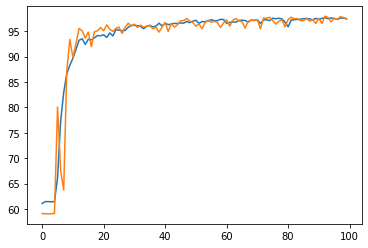

In [24]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)